<a href="https://colab.research.google.com/github/samer-glitch/samerelhajjhassan/blob/main/Part1%20Simplified%20to%20LightGBM%20and%20Part2%20Optimization%20task%20and%20Fine%20Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PSP_Jan_Feb_2019.csv to PSP_Jan_Feb_2019.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving psp_fees.csv to psp_fees.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving PSP_Jan_Feb_2019modfied1_with_tries.csv to PSP_Jan_Feb_2019modfied1_with_tries.csv


Dataset loaded. Time elapsed: 0.15 seconds
Preprocessing completed. Time elapsed: 0.26 seconds
Class imbalance handled. Time elapsed: 3.48 seconds

Model: LightGBM
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 40340, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4592
[LightGBM] [Info] Number of data points in the train set: 80522, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500981 -> initscore=0.003924
[LightGBM] 

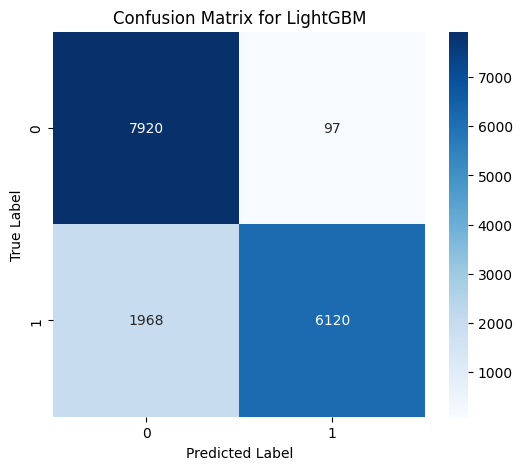

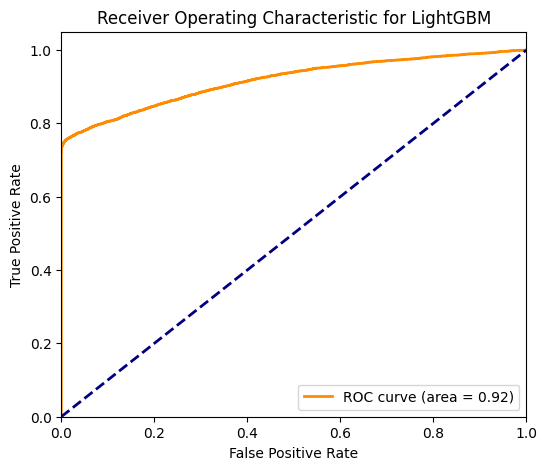

Accuracy Score: 0.8717789506364483
ROC AUC Score:(on test data) 0.917172484731074
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88      8017
           1       0.98      0.76      0.86      8088

    accuracy                           0.87     16105
   macro avg       0.89      0.87      0.87     16105
weighted avg       0.89      0.87      0.87     16105

Model LightGBM evaluated. Time elapsed: 232.99 seconds


In [4]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Start timer
start_time = time.time()

# Load the dataset
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')
print(f"Dataset loaded. Time elapsed: {time.time() - start_time:.2f} seconds")

# Preprocessing
X = transactions.drop(['success', 'tmsp'], axis=1)
y = transactions['success']
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
print(f"Preprocessing completed. Time elapsed: {time.time() - start_time:.2f} seconds")

# Handling class imbalance with ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_processed, y)
print(f"Class imbalance handled. Time elapsed: {time.time() - start_time:.2f} seconds")

# Define StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Define LightGBM model
model = ('LightGBM', LGBMClassifier(random_state=42), lgbm_param_grid)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate LightGBM model
model_name, model, param_grid = model
print("\033[1m" + f"\nModel: {model_name}" + "\033[0m")

grid_search = GridSearchCV(model, param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

cv_results = cross_val_score(best_model, X_resampled, y_resampled, cv=stratified_kfold, scoring='roc_auc')

print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC AUC Score (on validation set):", grid_search.best_score_)
print("Cross-Validation ROC AUC Scores:", cv_results)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, model_name)

plot_roc_curve(y_test, y_pred_proba, model_name)

print("\033[1m" + "Accuracy Score:" + "\033[0m", accuracy_score(y_test, y_pred))
print("\033[1m" + "ROC AUC Score:(on test data)" + "\033[0m", roc_auc_score(y_test, y_pred_proba))
print("\033[1m" + "Classification Report:\n" + "\033[0m", classification_report(y_test, y_pred))
print(f"Model {model_name} evaluated. Time elapsed: {time.time() - start_time:.2f} seconds")


In [5]:
feature_names = transactions.drop(['success', 'tmsp'], axis=1).columns
print("Features used in training:", feature_names.tolist())
# Check the feature names after preprocessing
processed_feature_names = preprocessor.get_feature_names_out()
print("Processed feature names:", processed_feature_names)

Features used in training: ['Unnamed: 0', 'country', 'amount', 'PSP', '3D_secured', 'card', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
Processed feature names: ['num__Unnamed: 0' 'num__amount' 'num__3D_secured' 'num__second'
 'num__minute' 'num__hour' 'num__day' 'num__weekday'
 'num__number_of_tries' 'cat__country_Austria' 'cat__country_Germany'
 'cat__country_Switzerland' 'cat__PSP_Goldcard' 'cat__PSP_Moneycard'
 'cat__PSP_Simplecard' 'cat__PSP_UK_Card' 'cat__card_Diners'
 'cat__card_Master' 'cat__card_Visa']


In [11]:
import pandas as pd
import random
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

# Load your data
transactions = pd.read_csv('PSP_Jan_Feb_2019modfied1_with_tries.csv')  # Replace with your actual file path
psp_fees_df = pd.read_csv('psp_fees.csv')
print("PSP Fees:", psp_fees_df)

# Define your preprocessor (ColumnTransformer)
numerical_features = ['amount', 'second', 'minute', 'hour', 'day', 'weekday', 'number_of_tries']
categorical_features = ['country', 'PSP', 'card']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor with your data
X = transactions.drop(['success', 'tmsp'], axis=1)  # Assuming 'success' and 'tmsp' are not features
y = transactions['success']  # Target variable
preprocessor.fit(X)

# Load and prepare your LightGBM model
# Replace the following line with your actual trained model loading
best_lgbm_model = LGBMClassifier()  # Replace with your actual trained model
best_lgbm_model.fit(preprocessor.transform(X), y)

def assign_weights(transaction):
    # Modify time weight based on specified conditions
    time_weight = 1.0
    if 12 <= transaction['hour'] <= 19 and transaction['number_of_tries'] == 1:
        time_weight = random.uniform(1.1, 1.3)

    # Modify weekend weight based on specified conditions
    weekend_weight = random.uniform(0.8, 1.2)
    if transaction['weekday'] in [4, 5] and transaction['hour'] >= 12 and transaction['number_of_tries'] == 1:
        weekend_weight = random.uniform(1.1, 1.3)

    weights = {
        'time_weight': time_weight,
        'country_weight': {'Germany': 0.8, 'Switzerland': 1.0, 'Austria': 1.15}.get(transaction['country'], 1.0),
        'card_weight': {'Diners': 0.9, 'Visa': 1.0, 'Master': 1.0}.get(transaction['card'], 1.0),
        'psp_weight': 1.0,
        'amount_weight': 0.5 if transaction['amount'] < 100 else 1.2 if transaction['amount'] > 500 else 1.0,
        'tries_weight': 0.9 if transaction['number_of_tries'] == 1 else 0,
        'weekend_weight': weekend_weight
    }
    return weights

def calculate_expected_cost(transaction, probability, psp_name, psp_fees_df):
    # Change threshold for 'Goldcard' assignment
    high_amount_threshold = 5000
    if transaction['amount'] > high_amount_threshold:
        psp_name = 'Goldcard'

    fees = psp_fees_df[psp_fees_df['PSP'] == psp_name]
    success_fee = fees['PSP_Fee_Successful'].values[0]
    failure_fee = fees['PSP_Fee_Failed'].values[0]

    weights = assign_weights(transaction)
    secure_cost_factor = 1.1 if transaction['3D_secured'] == 1 else 0.9

    expected_cost = ((probability * success_fee * weights['psp_weight'] * weights['time_weight'] *
                      weights['amount_weight'] * weights['tries_weight'] * weights['weekend_weight']) +
                     ((1 - probability) * failure_fee * weights['country_weight'] * weights['card_weight'])) * secure_cost_factor
    return expected_cost

def generate_random_date():
    year = random.randint(2024, 2025)
    month = random.randint(1, 12)
    day = random.randint(1, 28)
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    return datetime(year, month, day, hour, minute, second)  # Return datetime object

def generate_new_transaction():
    transaction = {
        'tmsp': generate_random_date(),
        'Unnamed: 0': random.randint(0, 1000),
        'country': random.choice(['Germany', 'Switzerland', 'Austria']),
        'amount': random.randint(5, 10000),
        'PSP': random.choice(['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']),
        '3D_secured': random.randint(0, 1),
        'card': random.choice(['Visa', 'Master', 'Diners']),
        'second': random.randint(0, 59),
        'minute': random.randint(0, 59),
        'hour': random.randint(0, 23),
        'day': random.randint(1, 28),
        'weekday': random.randint(0, 6),
        'number_of_tries': random.randint(1, 3)
    }
    return transaction

def find_best_psp(transaction, psp_fees_df, preprocessor, model):
    min_cost = float('inf')
    best_psp = None
    debug_info = {}

    processed_transaction = pd.DataFrame([transaction])
    processed_transaction = preprocessor.transform(processed_transaction)

    current_probability = model.predict_proba(processed_transaction)[:, 1][0]

    for psp in psp_fees_df['PSP']:
        transaction['PSP'] = psp
        cost = calculate_expected_cost(transaction, current_probability, psp, psp_fees_df)
        debug_info[psp] = {'Probability': current_probability, 'Cost': cost}
        if cost < min_cost:
            min_cost = cost
            best_psp = psp

    print("Debug Info:", debug_info)
    return best_psp, min_cost

num_transactions = 15
new_transactions = [generate_new_transaction() for _ in range(num_transactions)]

for transaction in new_transactions:
    best_psp, expected_cost = find_best_psp(transaction, psp_fees_df, preprocessor, best_lgbm_model)
    transaction['PSP'] = best_psp

    formatted_data = []
    formatted_data.append(f"Date & Time: {transaction['tmsp'].strftime('%Y-%m-%d %H:%M:%S')}")
    formatted_data.append(f"Country: {transaction['country']}")
    formatted_data.append(f"Amount: {transaction['amount']}")
    formatted_data.append(f"3D Secured: {'Yes' if transaction['3D_secured'] == 1 else 'No'}")
    formatted_data.append(f"Card Type: {transaction['card']}")
    formatted_data.append(f"Number of Tries: {transaction['number_of_tries']}")
    formatted_transaction_data = '\n'.join(formatted_data)

    table = PrettyTable()
    table.field_names = ["Transaction Details", "Recommended PSP"]
    table.align = "l"
    table.add_row([formatted_transaction_data, f"PSP: {best_psp}\nExpected Cost: {expected_cost:.2f}"])
    print(table)
    print("\n")


PSP Fees:           PSP  PSP_Fee_Successful  PSP_Fee_Failed
0   Moneycard                   5             2.0
1    Goldcard                  10             5.0
2     UK_Card                   3             1.0
3  Simplecard                   2             0.5
[LightGBM] [Info] Number of positive: 10228, number of negative: 40182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 50410, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202896 -> initscore=-1.368290
[LightGBM] [Info] Start training from score -1.368290
Debug Info: {'Moneycard': {'Probability': 0.3673754020519104, 'Cost': 1.1387242763065613}, 'Goldcard': {'Probability': 0.3673754020519104, 'Cost': 2.8468106907664033}, 'UK_Card': {'Pr